In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


Downloading and exploring the data

In [2]:
train_data = pd.read_csv(r'/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
train_data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
columns= train_data.columns
columns

Index(['emotion', 'pixels'], dtype='object')

In [4]:
train_data.shape

(28709, 2)

Making array of arrays based on string separated with spacebar in columns 'pixels'

In [5]:
array = []
for pixels in train_data.loc[:,'pixels']:
    array.append(np.fromstring(pixels, sep =" ", dtype = int))
array[:10]

[array([ 70,  80,  82, ..., 106, 109,  82]),
 array([151, 150, 147, ..., 193, 183, 184]),
 array([231, 212, 156, ...,  88, 110, 152]),
 array([ 24,  32,  36, ..., 142, 143, 142]),
 array([ 4,  0,  0, ..., 30, 29, 30]),
 array([55, 55, 55, ..., 34, 30, 57]),
 array([ 20,  17,  19, ...,  99, 107, 118]),
 array([ 77,  78,  79, ..., 125,  67,  68]),
 array([85, 84, 90, ..., 58, 73, 84]),
 array([255, 254, 255, ..., 254, 255, 255])]

In [6]:
print(f"Number of samples: {len(array)}, Number of pixels per sample: {len(array[0])}")
X = np.array(array)
Y = np.array(train_data.loc[:,'emotion'])

Number of samples: 28709, Number of pixels per sample: 2304


In [7]:
print("Shape of data: ",X.shape)
print("Value type of data: ",type(X[0,0]))

Shape of data:  (28709, 2304)
Value type of data:  <class 'numpy.int64'>


In [8]:
print(np.isnan(X.any(axis = 0)).sum())
print(X.max(), X.min())

0
255 0


Rescalling values from 0 - 255 to 0 - 1

In [9]:
#Rescalling values
X = X / 255.0
print(X.max(), X.min())

1.0 0.0


In [10]:
number_of_targets = np.unique(Y).shape[0]
number_of_targets

7

Creating dictionary with emotion name (values) based on their indexes (keys)

In [11]:
target_meanings = {}
string = "0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral"
for pair in list(string.split(sep = ',')):
    target_meanings[int(pair.split(sep = '=')[0])] = pair.split(sep = '=')[1]

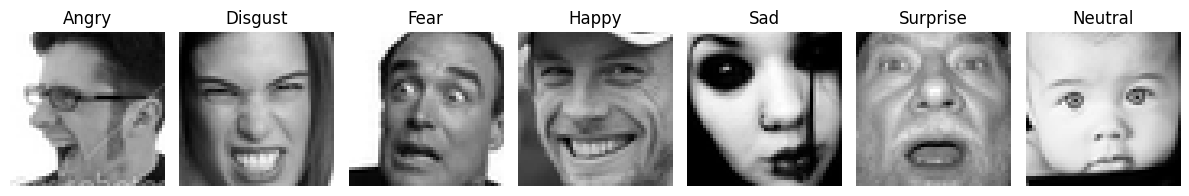

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = number_of_targets, figsize = (12, 6))
for target_idx in range(number_of_targets):
    label_idx = np.where(Y == target_idx)[0]
    random_img = X[np.random.choice(label_idx)]
    axs[target_idx].imshow(random_img.reshape(48, 48), cmap = 'gray')
    axs[target_idx].set_title(target_meanings[target_idx])
    axs[target_idx].axis('off')
    axs[target_idx].grid(False)
plt.tight_layout()
plt.show()
    


In [13]:
X.shape

(28709, 2304)

In [14]:
N = X.shape[0]
X = X.reshape((N ,48, 48))
X = np.expand_dims(X, axis = 3) #adding aditional dimension for color channel
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(22967, 48, 48, 1) (22967,) (5742, 48, 48, 1) (5742,)


In [15]:
H, W, C = x_train.shape[1:]

Creating and testing various models with different architecture, looking for best, not overtrained to cope with

In [16]:
i = Input(shape = (H, W, C, ))
x = Conv2D(32, kernel_size = (3,3),padding = 'valid', strides = 2, activation = 'relu')(i)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size = (3,3), padding = 'valid',strides = 2, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size = (3,3), padding = 'valid',strides = 2, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(number_of_targets, activation = 'softmax')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 23, 23, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 23, 23, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856 

In [17]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20)

Epoch 1/20
718/718 [==============================] - 8s 5ms/step - loss: 1.8117 - accuracy: 0.3693 - val_loss: 1.6566 - val_accuracy: 0.3870
Epoch 2/20
718/718 [==============================] - 3s 5ms/step - loss: 1.3043 - accuracy: 0.5057 - val_loss: 1.4793 - val_accuracy: 0.4415
Epoch 3/20
718/718 [==============================] - 3s 5ms/step - loss: 1.0393 - accuracy: 0.6163 - val_loss: 1.4734 - val_accuracy: 0.4460
Epoch 4/20
718/718 [==============================] - 3s 5ms/step - loss: 0.7284 - accuracy: 0.7400 - val_loss: 1.8199 - val_accuracy: 0.4493
Epoch 5/20
718/718 [==============================] - 3s 5ms/step - loss: 0.4637 - accuracy: 0.8365 - val_loss: 1.8594 - val_accuracy: 0.4648
Epoch 6/20
718/718 [==============================] - 3s 5ms/step - loss: 0.3310 - accuracy: 0.8906 - val_loss: 2.0701 - val_accuracy: 0.4746
Epoch 7/20
718/718 [==============================] - 3s 5ms/step - loss: 0.2294 - accuracy: 0.9256 - val_loss: 2.6739 - val_accuracy: 0.4768
Epoch 

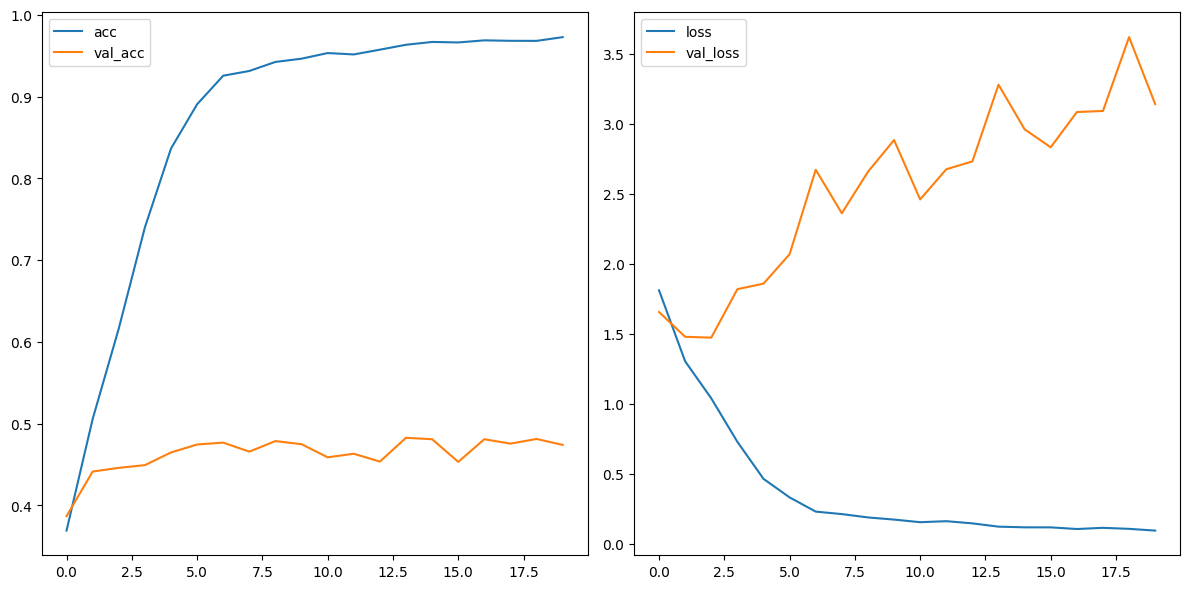

In [18]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axs[0].plot(model.history.history['accuracy'], label = 'acc')
axs[0].plot(model.history.history['val_accuracy'], label = 'val_acc')
axs[0].legend()
axs[1].plot(model.history.history['loss'], label = 'loss')
axs[1].plot(model.history.history['val_loss'], label = 'val_loss')
axs[1].legend()
plt.tight_layout()
plt.show()

Overtrained model (based on validation loss function)

****Complex neural network using MaxPooling2D and padding****

In [19]:
i_2 = Input(shape = ((H,W,C, )))
x = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(i_2)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling2D()(x)

x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.4)(x)
o_2 = Dense(number_of_targets, activation = 'softmax')(x)
model_2 = Model(i_2, o_2)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 16)        2320      
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 16)        2320

In [20]:
batch_size = 256

steps_per_epoch = X.shape[0] // batch_size
model_2.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = SGD(learning_rate = 0.005))
model_2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 30, batch_size = batch_size, steps_per_epoch = steps_per_epoch)

Epoch 1/30
112/112 [==============================] - 8s 36ms/step - loss: 2.4587 - accuracy: 0.1866 - val_loss: 1.8862 - val_accuracy: 0.1945
Epoch 2/30
112/112 [==============================] - 3s 28ms/step - loss: 1.9951 - accuracy: 0.2078 - val_loss: 1.8310 - val_accuracy: 0.2217
Epoch 3/30
112/112 [==============================] - 3s 28ms/step - loss: 1.9096 - accuracy: 0.2157 - val_loss: 1.8021 - val_accuracy: 0.2353
Epoch 4/30
112/112 [==============================] - 3s 28ms/step - loss: 1.8632 - accuracy: 0.2298 - val_loss: 1.7846 - val_accuracy: 0.2534
Epoch 5/30
112/112 [==============================] - 3s 28ms/step - loss: 1.8448 - accuracy: 0.2297 - val_loss: 1.7758 - val_accuracy: 0.2555
Epoch 6/30
112/112 [==============================] - 3s 28ms/step - loss: 1.8290 - accuracy: 0.2378 - val_loss: 1.7666 - val_accuracy: 0.2720
Epoch 7/30
112/112 [==============================] - 3s 28ms/step - loss: 1.8192 - accuracy: 0.2416 - val_loss: 1.7659 - val_accuracy: 0.2684

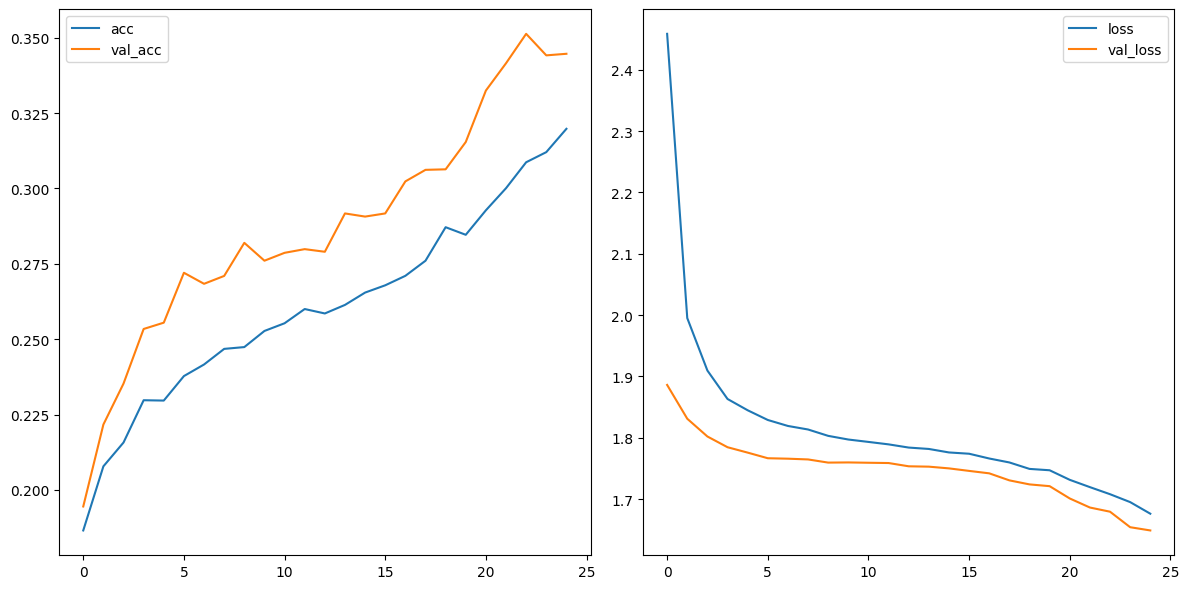

In [21]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axs[0].plot(model_2.history.history['accuracy'], label = 'acc')
axs[0].plot(model_2.history.history['val_accuracy'], label = 'val_acc')
axs[0].legend()
axs[1].plot(model_2.history.history['loss'], label = 'loss')
axs[1].plot(model_2.history.history['val_loss'], label = 'val_loss')
axs[1].legend()
plt.tight_layout()
plt.show()

In [22]:
i_3 = Input(shape = (H, W, C, ))
x = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(i_3)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (3,3))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
o_3 = Dense(number_of_targets, activation = 'softmax')(x)
model_3 = Model(i_3, o_3)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        18464     
                                                                 
 batch_normalization_13 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 48, 16)        4624

In [23]:
def learning_rate_scheduler2(epoch):
    learning_rate = 0.0001
    if epoch % 10 == 0:
        learning_rate = learning_rate - 0.00001 * epoch // 10
    return learning_rate

lr_scheduler2 = LearningRateScheduler(learning_rate_scheduler2)

In [24]:
model_3.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = SGD(learning_rate = 0.0003, momentum = 0.95))
model_3.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = batch_size, steps_per_epoch = steps_per_epoch, callbacks = [lr_scheduler2])

Epoch 1/50
112/112 [==============================] - 6s 36ms/step - loss: 2.1621 - accuracy: 0.2089 - val_loss: 1.9054 - val_accuracy: 0.2544 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - 3s 28ms/step - loss: 1.8404 - accuracy: 0.2559 - val_loss: 1.8749 - val_accuracy: 0.2821 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - 3s 28ms/step - loss: 1.7934 - accuracy: 0.2731 - val_loss: 1.8260 - val_accuracy: 0.2959 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - 3s 28ms/step - loss: 1.7665 - accuracy: 0.2877 - val_loss: 1.7698 - val_accuracy: 0.3102 - lr: 1.0000e-04
Epoch 5/50
112/112 [==============================] - 3s 28ms/step - loss: 1.7500 - accuracy: 0.2973 - val_loss: 1.7222 - val_accuracy: 0.3264 - lr: 1.0000e-04
Epoch 6/50
112/112 [==============================] - 3s 28ms/step - loss: 1.7325 - accuracy: 0.3071 - val_loss: 1.6887 - val_accuracy: 0.3382 - lr: 1.0000e-04
Epoch 7/50
112/112 [====================

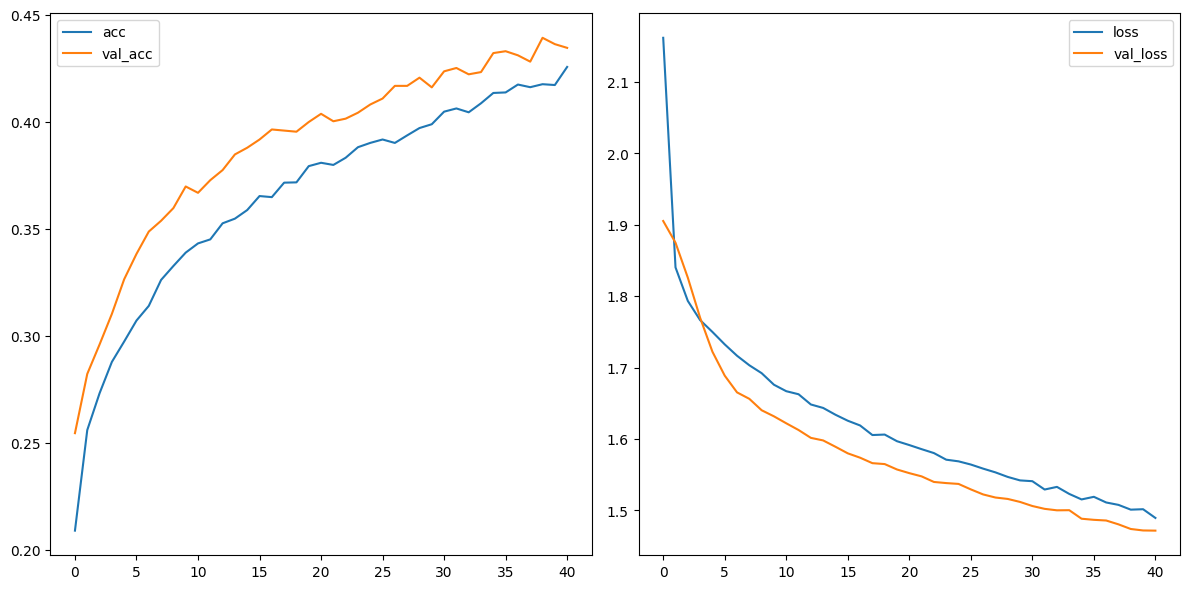

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axs[0].plot(model_3.history.history['accuracy'], label = 'acc')
axs[0].plot(model_3.history.history['val_accuracy'], label = 'val_acc')
axs[0].legend()
axs[1].plot(model_3.history.history['loss'], label = 'loss')
axs[1].plot(model_3.history.history['val_loss'], label = 'val_loss')
axs[1].legend()
plt.tight_layout()
plt.show()

Doing further evaluation based on complex model_3 results. Model was chosen based on his well-looking plots

180/180 [==============================] - 1s 2ms/step


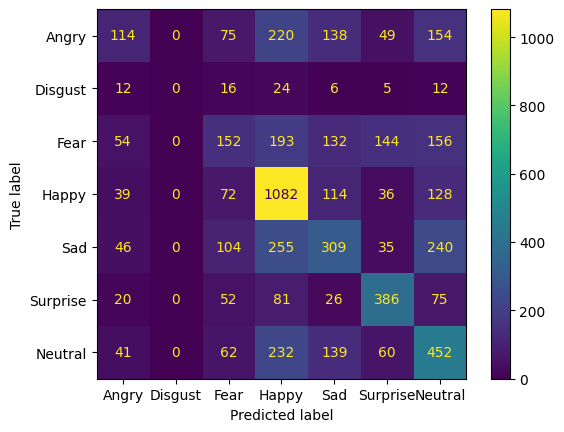

Label: Angry was predicted with successfulness: 15.2%
Label: Disgust was predicted with successfulness: 0.0%
Label: Fear was predicted with successfulness: 18.29%
Label: Happy was predicted with successfulness: 73.56%
Label: Sad was predicted with successfulness: 31.24%
Label: Surprise was predicted with successfulness: 60.31%
Label: Neutral was predicted with successfulness: 45.84%


Accuracy score for model based on NN no. 3 (input: i_3, output o_3), predicting on 1000 samples:  0.4345175896900035


In [26]:
#confusion matrix display
y_pred = model_3.predict(x_test).argmax(axis = 1)
cm = confusion_matrix(y_test, y_pred, labels = list(target_meanings.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(target_meanings.values()))
disp.plot()
plt.show()

for index, row in enumerate(cm):
    print(f"Label: {target_meanings[index]} was predicted with successfulness: {round(100 * row[index] / sum(row), 2)}%")
    
print("\n\nAccuracy score for model based on NN no. 3 (input: i_3, output o_3), predicting on 1000 samples: ", accuracy_score(y_test, y_pred))

Disgust wasn't predicted even once. Let's see how well model predict if there's no disgust emotion included in data

In [27]:
print(X.shape)
print(np.where(Y == 1)[0].shape)
X_filtered = np.delete(X, np.where(Y == 1)[0], axis = 0)
Y_filtered = np.delete(Y, np.where(Y == 1)[0], axis = 0)
print(f"X shape after deleting: {X_filtered.shape}, Y shape after deleting: {Y_filtered.shape}")

x_filter_train, x_filter_test, y_filter_train, y_filter_test = train_test_split(X_filtered, Y_filtered, random_state = 42, test_size = 0.2)

#creating new model to have clear training history
model_4 = Model(i_3, o_3)
model_4.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = SGD(learning_rate = 0.01, momentum = 0.95))
r = model_4.fit(x_filter_train, y_filter_train, validation_data = (x_filter_test, y_filter_test), epochs = 30, shuffle = True, steps_per_epoch = steps_per_epoch, batch_size = batch_size, callbacks = [lr_scheduler2])

(28709, 48, 48, 1)
(436,)
X shape after deleting: (28273, 48, 48, 1), Y shape after deleting: (28273,)
Epoch 1/30
112/112 [==============================] - 5s 34ms/step - loss: 1.4625 - accuracy: 0.4242 - val_loss: 1.3774 - val_accuracy: 0.4665 - lr: 1.0000e-04
Epoch 2/30
112/112 [==============================] - 3s 28ms/step - loss: 1.4589 - accuracy: 0.4245 - val_loss: 1.3715 - val_accuracy: 0.4568 - lr: 1.0000e-04
Epoch 3/30
112/112 [==============================] - 3s 28ms/step - loss: 1.4545 - accuracy: 0.4245 - val_loss: 1.3691 - val_accuracy: 0.4647 - lr: 1.0000e-04
Epoch 4/30
112/112 [==============================] - 3s 28ms/step - loss: 1.4467 - accuracy: 0.4271 - val_loss: 1.3679 - val_accuracy: 0.4633 - lr: 1.0000e-04
Epoch 5/30
112/112 [==============================] - 3s 28ms/step - loss: 1.4467 - accuracy: 0.4270 - val_loss: 1.3628 - val_accuracy: 0.4644 - lr: 1.0000e-04
Epoch 6/30
112/112 [==============================] - 3s 28ms/step - loss: 1.4386 - accuracy: 0.4

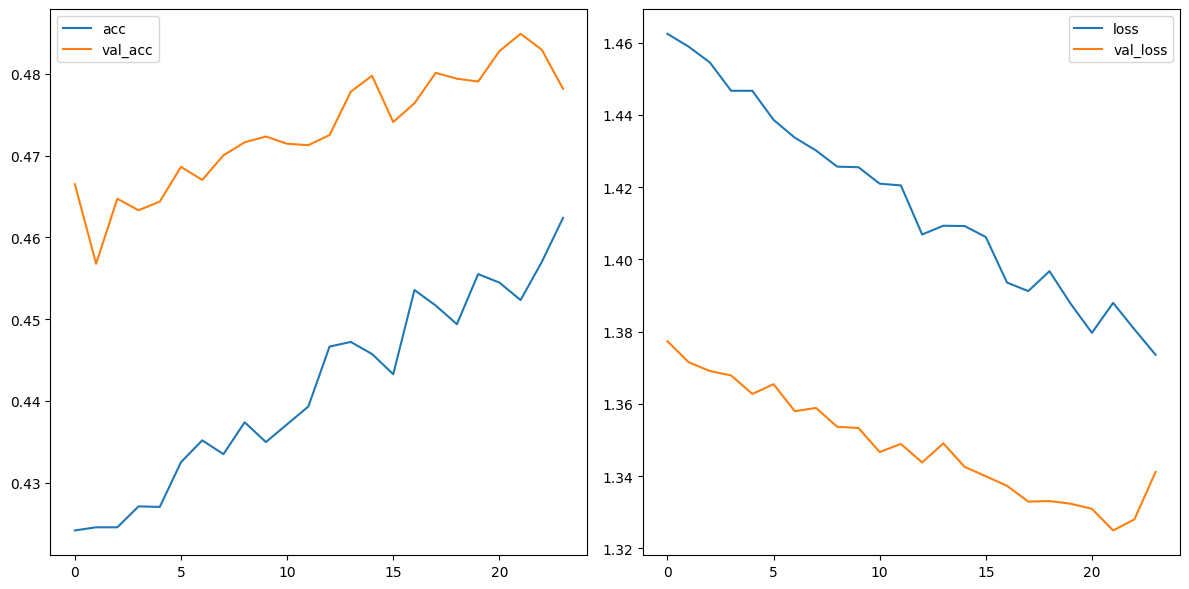

In [28]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axs[0].plot(r.history['accuracy'], label = 'acc')
axs[0].plot(r.history['val_accuracy'], label = 'val_acc')
axs[0].legend()
axs[1].plot(r.history['loss'], label = 'loss')
axs[1].plot(r.history['val_loss'], label = 'val_loss')
axs[1].legend()
plt.tight_layout()
plt.show()

Best accuracy without overtraining the model - 50%

Targets dictionary after deleting disgust emotion:  {0: 'Angry', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
32/32 [==============================] - 0s 3ms/step


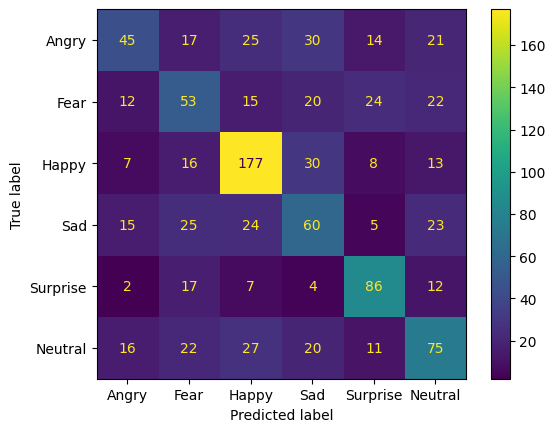

Label: Angry was predicted with successfulness: 29.61%
Label: Fear was predicted with successfulness: 36.3%
Label: Happy was predicted with successfulness: 70.52%
Label: Sad was predicted with successfulness: 39.47%
Label: Surprise was predicted with successfulness: 67.19%


Accuracy score for model based on NN no. 3 (input: i_3, output o_3), predicting on 1000 samples:  0.496


In [29]:
#deleting disgust emotion from labels dictionary
target_meanings_copy = copy.copy(target_meanings)
del target_meanings_copy[1]
print("Targets dictionary after deleting disgust emotion: ", target_meanings_copy)

#creating confusion matrix
x_test_data, y_test_data = shuffle(x_filter_train, y_filter_train, random_state = 2, n_samples = 1000)
y_pred = model_4.predict(x_test_data).argmax(axis = 1)
cm = confusion_matrix(y_test_data, y_pred, labels = list(target_meanings_copy.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(target_meanings_copy.values()))
disp.plot()
plt.show()


for index, row in enumerate(cm[:-1]):
    pivot_idx = index
    if index >= 1:
        pivot_idx += 1
    print(f"Label: {target_meanings_copy[pivot_idx]} was predicted with successfulness: {round(100 * row[index] / sum(row), 2)}%")

print("\n\nAccuracy score for model based on NN no. 3 (input: i_3, output o_3), predicting on 1000 samples: ", accuracy_score(y_test_data, y_pred))